In [1]:
# package(s) related to time, space and id
import datetime
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import digital_twin.core as core
import digital_twin.model as model

In [2]:
Site = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasContainer, core.HasResource), {})

TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                                    core.Processor, core.HasResource, core.HasFuel), {})

In [3]:
my_env = simpy.Environment()

# sites data in database
data_stock_clay = {"env": my_env,
                   "name": "Clay_Stock",
                   "geometry": shapely.geometry.Point(5.019298185633251, 52.94239823421129),  # lon, lat
                   "capacity": 150000,
                   "level": 150000}
data_stock_sand = {"env": my_env,
                   "name": "Sand_Stock",
                   "geometry": shapely.geometry.Point(5.271417603333632, 52.9638452897506),  # lon, lat
                   "capacity": 150_000,
                   "level": 150_000}

In [4]:
site_count = 20

# layer data from database
data_clay = {"start": [5.054676856441372, 52.94042293840172], # Den Oever (lon, lat)
             "stop": [5.294877712236641, 53.06686424241725], # Kornwerderzand (lon, lat)
             "capacity": 5_000,
             "name": "Clay_Layer"}
data_sand = {"start": [5.052051052879287,52.9421894472733], # Den Oever (lon, lat)
             "stop": [5.292216781509101,53.06886359869087], # Kornwerderzand (lon, lat)
             "capacity": 5_000,
             "name": "Sand_Layer"}

# create the site objects
stocks = []
for data in [data_stock_clay, data_stock_sand]:
    stock = Site(**data)
    stocks.append(stock)

# create the sites
sites = []
for data_layer in [data_clay, data_sand]:
    start = data_layer['start']
    stop = data_layer['stop']

    # generate the evenly spaced locations between the selected start and stop points
    lons = np.linspace(start[0], stop[0], num=site_count)
    lats = np.linspace(start[1], stop[1], num=site_count)

    # create a Site object for each location
    layer_sites = []
    for i in range(site_count):
        data_site = {"env": my_env,
                     "name": data_layer["name"] + '_' + format(i, '02.0f'),
                     "geometry": shapely.geometry.Point(lons[i], lats[i]),
                     "capacity": data_layer["capacity"]}
        site = Site(**data_site)
        layer_sites.append(site)
    sites.append(layer_sites)

In [5]:
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

data_hopper = {"env": my_env,
               "name": "Hopper",
               "geometry": shapely.geometry.Point(5.070195628786471, 52.93917167503315),  # lon, lat
               "rate": 2,
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=2, v_full=1.5),
               "fuel_capacity": 150_000,
               "fuel_level": 150_000}

# create the transport processing resource
hopper = TransportProcessingResource(**data_hopper)

In [6]:
activities = []

# define the clay layer Activities
clay_layer_index = 0
clay_sites = sites[clay_layer_index]
for i, clay_site in enumerate(clay_sites):
    # for the first site we do not need to define any condition
    condition = None if i == 0 else model.LevelCondition(container=clay_sites[i-1], min_level=data_clay["capacity"])
    activity = model.Activity(env=my_env,
                              name="Clay_Placement_S" + format(i+1, '02.0f'),
                              origin=stocks[clay_layer_index],
                              destination=clay_site,
                              loader=hopper,
                              mover=hopper,
                              unloader=hopper,
                              start_condition=condition)
    activities.append(activity)
        
# define the sand layer Activities
sand_layer_index = 1
sand_sites = sites[sand_layer_index]
for i, sand_site in enumerate(sand_sites):
    # for the first site we do not need to define a condition on the previous site
    prev_site_condition = model.TrueCondition() if i == 0 else model.LevelCondition(container=sand_sites[i-1], 
                                                                          min_level=sand_sites[i-1].container.capacity)
    prev_layer_sites = sites[clay_layer_index]
    prev_layer_condition = model.LevelCondition(prev_layer_sites[i], min_level=prev_layer_sites[i].container.capacity)
    start_condition = model.AndCondition([prev_site_condition, prev_layer_condition])
    activity = model.Activity(env=my_env,
                              name="Sand_Placement_S" + format(i+1, '02.0f'),
                              origin=stocks[sand_layer_index],
                              destination=sand_site,
                              loader=hopper,
                              mover=hopper,
                              unloader=hopper,
                              start_condition=start_condition)
    activities.append(activity)


In [7]:
my_env.epoch = datetime.datetime.now()

my_env.run()

print("\n*** Installation of dike finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now))))

T=000.00 Start condition is satisfied, Clay_Placement_S01 transporting from Clay_Stock to Clay_Layer_00 started
Using Hopper to process 1000
T=000.00 Clay_Placement_S02 to Clay_Layer_01 suspended
T=000.00 Clay_Placement_S03 to Clay_Layer_02 suspended
T=000.00 Clay_Placement_S04 to Clay_Layer_03 suspended
T=000.00 Clay_Placement_S05 to Clay_Layer_04 suspended
T=000.00 Clay_Placement_S06 to Clay_Layer_05 suspended
T=000.00 Clay_Placement_S07 to Clay_Layer_06 suspended
T=000.00 Clay_Placement_S08 to Clay_Layer_07 suspended
T=000.00 Clay_Placement_S09 to Clay_Layer_08 suspended
T=000.00 Clay_Placement_S10 to Clay_Layer_09 suspended
T=000.00 Clay_Placement_S11 to Clay_Layer_10 suspended
T=000.00 Clay_Placement_S12 to Clay_Layer_11 suspended
T=000.00 Clay_Placement_S13 to Clay_Layer_12 suspended
T=000.00 Clay_Placement_S14 to Clay_Layer_13 suspended
T=000.00 Clay_Placement_S15 to Clay_Layer_14 suspended
T=000.00 Clay_Placement_S16 to Clay_Layer_15 suspended
T=000.00 Clay_Placement_S17 to Cla

  object:      Hopper contains: 1000
  from:        5.01930 52.94240
  to:          5.11789 52.97370
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Clay_Layer_05 contains: 5000
T=992437.16 Stop condition is satisfied, Clay_Placement_S06 transporting from Clay_Stock to Clay_Layer_05 complete
T=993600.00 Start condition is satisfied, Clay_Placement_S07 transporting from Clay_Stock to Clay_Layer_06 started
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5.11789 52.97370
  to:          5.27142 52.96385
Processed 1000:
  from:        Sand_Stock contains: 126000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.27142 52.96385
  to:          5.10261 52.96886
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Sand_Layer_04 contains: 4000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:

Moved:
  object:      Hopper contains: 0
  from:        5.16846 53.00032
  to:          5.27142 52.96385
Processed 1000:
  from:        Sand_Stock contains: 107000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.27142 52.96385
  to:          5.15317 52.99553
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Sand_Layer_08 contains: 3000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5.15317 52.99553
  to:          5.01930 52.94240
Processed 1000:
  from:        Clay_Stock contains: 100000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.01930 52.94240
  to:          5.16846 53.00032
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Clay_Layer_09 contains: 5000
T=1918356.32 Stop condition is satisfied, Clay_Placement_S10 transporting fro

Moved:
  object:      Hopper contains: 0
  from:        5.20638 53.02028
  to:          5.27142 52.96385
Processed 1000:
  from:        Sand_Stock contains: 94000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.27142 52.96385
  to:          5.19109 53.01553
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Sand_Layer_11 contains: 1000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5.19109 53.01553
  to:          5.01930 52.94240
Processed 1000:
  from:        Clay_Stock contains: 87000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.01930 52.94240
  to:          5.20638 53.02028
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Clay_Layer_12 contains: 3000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:  

  to:          5.27142 52.96385
Processed 1000:
  from:        Sand_Stock contains: 80000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.27142 52.96385
  to:          5.21637 53.02886
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Sand_Layer_13 contains: 5000
T=3405498.40 Stop condition is satisfied, Sand_Placement_S14 transporting from Sand_Stock to Sand_Layer_13 complete
T=3405600.00 Start condition is satisfied, Sand_Placement_S15 transporting from Sand_Stock to Sand_Layer_14 started
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5.21637 53.02886
  to:          5.01930 52.94240
Processed 1000:
  from:        Clay_Stock contains: 73000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.01930 52.94240
  to:          5.24431 53.04025
Processed 1000:
  from:        Hoppe

Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Clay_Layer_18 contains: 2000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5.28224 53.06021
  to:          5.27142 52.96385
Processed 1000:
  from:        Sand_Stock contains: 64000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.27142 52.96385
  to:          5.26694 53.05553
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Sand_Layer_17 contains: 1000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5.26694 53.05553
  to:          5.01930 52.94240
Processed 1000:
  from:        Clay_Stock contains: 57000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.01930 52.94240
  to:          5.28224 53.06021
Processed 1000:
  from:        Hopper contains: 0


  object:      Hopper contains: 0
  from:        5.29222 53.06886
  to:          5.27142 52.96385
Processed 1000:
  from:        Sand_Stock contains: 53000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.27142 52.96385
  to:          5.29222 53.06886
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Sand_Layer_19 contains: 2000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5.29222 53.06886
  to:          5.27142 52.96385
Processed 1000:
  from:        Sand_Stock contains: 52000
  by:          Hopper
  to:          Hopper contains: 1000
Moved:
  object:      Hopper contains: 1000
  from:        5.27142 52.96385
  to:          5.29222 53.06886
Processed 1000:
  from:        Hopper contains: 0
  by:          Hopper
  to:          Sand_Layer_19 contains: 3000
Using Hopper to process 1000
Moved:
  object:      Hopper contains: 0
  from:        5

In [8]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
class plot:
    """plot class"""

    def vessel_planning(vessels, activities, colors, web=False):
        """create a plot of the planning of vessels"""

        def get_segments(series, activity, y_val):
            """extract 'start' and 'stop' of activities from log"""
            x = []
            y = []
            for i, v in series.iteritems():
                if v == activity + ' start':
                    start = i
                if v == activity + ' stop':
                    x.extend((start, start, i, i, i))
                    y.extend((y_val, y_val, y_val, y_val, None))
            return x, y

        # organise logdata into 'dataframes' 
        dataframes = []
        for vessel in vessels:
            df = pd.DataFrame(
                {'log_value': vessel.value, 'log_string': vessel.log}, vessel.t)
            dataframes.append(df)
        df = dataframes[0]

        # prepare traces for each of the activities
        traces = []
        for i, activity in enumerate(activities):
            x_combined = []
            y_combined = []
            for k, df in enumerate(dataframes):
                y_val = vessels[k].name
                x, y = get_segments(
                    df['log_string'], activity=activity, y_val=y_val)
                x_combined.extend(x)
                y_combined.extend(y)
            traces.append(go.Scatter(
                name=activity,
                x=x_combined,
                y=y_combined,
                mode='lines',
                hoverinfo='y+name',
                line=dict(color=colors[i], width=10),
                connectgaps=False))
        
        # prepare layout of figure
        layout = go.Layout(
            title='Vessel planning',
            hovermode='closest',
            legend=dict(x=0, y=-.2, orientation="h"),
            xaxis=dict(
                title='Time',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'),
                range=[0, vessel.t[-1]]),
            yaxis=dict(
                title='Vessels',
                titlefont=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f')))
        
        # plot figure
        init_notebook_mode(connected=True)        
        fig = go.Figure(data=traces, layout=layout)
        return iplot(fig, filename='news-source')

In [14]:
vessels = [hopper]
activities = ['loading', 'unloading', 'sailing full', 'sailing empty', 'fuel loading']
colors = {0:'rgb(55,126,184)', 1:'rgb(77,175,74)', 2:'rgb(255,0,0)', 3:'rgb(255,150,0)', 4: 'rgb(0,0,0)'}

plot.vessel_planning(vessels, activities, colors)

In [10]:
log_locations = []

for item in range(len(hopper.log)):
    if hopper.log[item] == "fuel consumed":
        log_locations.append(item)

fuel_consumption = []
fuel_consumption_cum = 0
fuel_consumption_times = []

for i in log_locations:
    fuel_consumption_cum += hopper.value[i]
    fuel_consumption.append(fuel_consumption_cum)
    fuel_consumption_times.append(hopper.t[i])

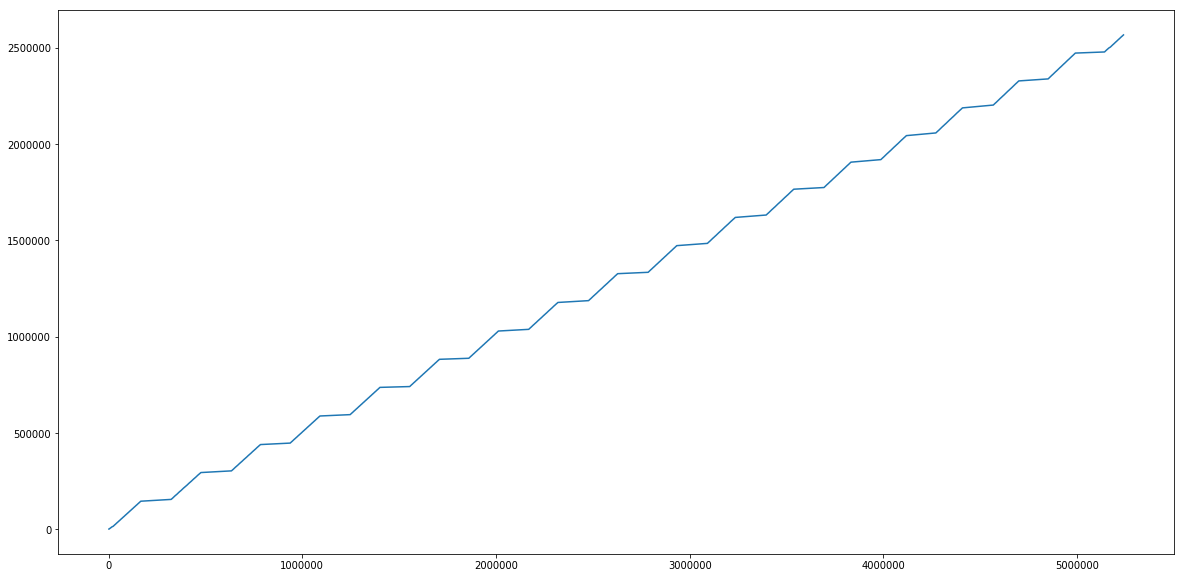

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = [20,10])
plt.plot(fuel_consumption_times, fuel_consumption)
plt.show()

In [12]:
for i in range(len(hopper.log)):
    if i > 0:
        print(int((hopper.t[i] - hopper.t[i - 1])), hopper.log[i])
    else:
        print(hopper.log[i], hopper.t[i])
    
    if i > 1000:
        break

sailing empty start 0
1720 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 sailing full start
1592 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
1194 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 sailing full start
1592 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
1194 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 sailing full start
1592 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
1194 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 sailing full start
1592 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
1194 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loadin

0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
3713 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 sailing full start
5723 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
4820 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 sailing full start
7048 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
3713 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 sailing full start
5723 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 unloading stop
0 sailing empty start
4820 fuel consumed
0 sailing empty stop
0 loading start
500 fuel consumed
0 loading stop
0 fuel loading start
148287 fuel loading stop
0 sailing full start
7048 fuel consumed
0 sailing full stop
0 unloading start
500 fuel consumed
0 

In [ ]:
# fuel consumption per stap
# voor project
# per cyclus
# per m3
# 
# drie projecten
## verschillende work method
## verschillende grond
## verschillende dump